In [377]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import mutual_info_classif

import category_encoders as ce
import seaborn as sns

In [378]:
data = pd.read_csv("data.csv").drop('Unnamed: 0', axis=1).replace('Yes', 1).replace('No', 0)

In [379]:
X = data.drop('Is Back', axis=1)
y = data['Is Back']

## Phase 0

Customer ID is unique for each row so it has no specific information for the model, thus it's dropped.

In [380]:
X = X.drop('Customer ID', axis=1)

Month and Weekday features are added to dataset, so models can capture any data related to the date.


In [381]:
X['Date'] = pd.to_datetime(X['Date'])
X['Month'] = X['Date'].dt.month
X['Weekday'] = X['Date'].dt.day % 7
X = X.drop('Date', axis=1)

Unit Price of each row is calculated.

In [149]:
X['Unit Price'] = X['Total Price'] / X['Total Quantity'].replace(0,1)

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [158]:
kbd = KBinsDiscretizer(encode = 'ordinal', strategy='quantile')

Total Price, Total Quantity, Unit Price are discretized in order to extract new categorical features which can be joined with other features.

In [382]:
X_train['price_label'] = kbd.fit_transform(X_train['Total Price'].values.reshape((-1,1)))
X_test['price_label'] = kbd.transform(X_test['Total Price'].values.reshape((-1,1)))

X_train['quantity_label'] = kbd.fit_transform(X_train['Total Quantity'].values.reshape((-1,1)))
X_test['quantity_label'] = kbd.transform(X_test['Total Quantity'].values.reshape((-1,1)))

X_train['unit_price_label'] = kbd.fit_transform(X_train['Unit Price'].values.reshape((-1,1)))
X_test['unit_price_label'] = kbd.transform(X_test['Unit Price'].values.reshape((-1,1)))

/home/diyar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/diyar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/diyar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Categorical Features are joined together to make new features.

In [383]:
cat_cols = ['Country', 'Month', 'Weekday', 
            'price_label', 'quantity_label', 'unit_price_label']

In [384]:
new_features = []
for i, col in enumerate(cat_cols):
    for feature in cat_cols[i+1:]:
        X_train[col+'--'+feature] = X_train[col].astype(str) + '-' + X_train[feature].astype(str)
        X_test[col+'--'+feature] = X_test[col].astype(str) + '-' + X_test[feature].astype(str)
        new_features.append(col+'--'+feature)

/home/diyar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/diyar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


All categorical features are encoded using target encoding, using other encoding methods such as one-hot encoding will lead to having too much columns.

In [386]:
te = ce.TargetEncoder(cols = new_features + cat_cols)
X_train_te = te.fit_transform(X_train, y_train)
X_test_te = te.transform(X_test)

In [388]:
gain = mutual_info_classif(X_train_te, y_train)
for i in (np.argsort(gain)):
    print(X_test_te.columns[i], gain[i])

Total Quantity 0.0
Weekday--unit_price_label 0.0
Weekday--price_label 0.0
unit_price_label 0.0
price_label 0.0
quantity_label--unit_price_label 0.0
Country 0.0
Unit Price 0.0025856438299445283
quantity_label 0.005585495543625196
Weekday--quantity_label 0.007356270482681504
Purchase Count 0.00782186480101199
Weekday 0.011452842991936274
Country--unit_price_label 0.014459616408685871
Country--Weekday 0.014779508190489121
Country--quantity_label 0.015611070619537593
Country--price_label 0.017603709769447695
price_label--unit_price_label 0.01886478371424838
price_label--quantity_label 0.02040090239393888
Total Price 0.02390848209288099
Month--price_label 0.05535171436359598
Month 0.059049235664329514
Month--Weekday 0.059874823102991304
Month--quantity_label 0.06973284591471263
Month--unit_price_label 0.07215168821749662
Country--Month 0.07279918317512046


In [391]:
corrs = X_test_te.join(y_test).corr()['Is Back']
for i in (np.argsort(corrs)[:-1]):
    print(X_test_te.columns[i], corrs[i])

Total Quantity -0.03680151337191328
Total Price -0.030121752307103955
Unit Price -0.01838237305561165
Purchase Count 0.01607261064164402
Country--Weekday 0.02121415849651101
Weekday--price_label 0.027009580133549586
unit_price_label 0.027804030091968204
Country 0.03064097505160503
Weekday 0.03874084728233686
price_label--quantity_label 0.04092866239508586
price_label 0.04172150156225894
Country--quantity_label 0.043584265142299405
Weekday--unit_price_label 0.04702280230349451
Weekday--quantity_label 0.06085080385180608
quantity_label 0.06268817476639225
price_label--unit_price_label 0.0669153882427656
Country--unit_price_label 0.07280557858901403
Country--price_label 0.07825824587904205
quantity_label--unit_price_label 0.08466901842704277
Month--quantity_label 0.3555423055801484
Country--Month 0.3723973405454998
Month--unit_price_label 0.3780249980783016
Month--Weekday 0.3785403149935379
Month 0.39168838667127226
Month--price_label 0.39240414666205653


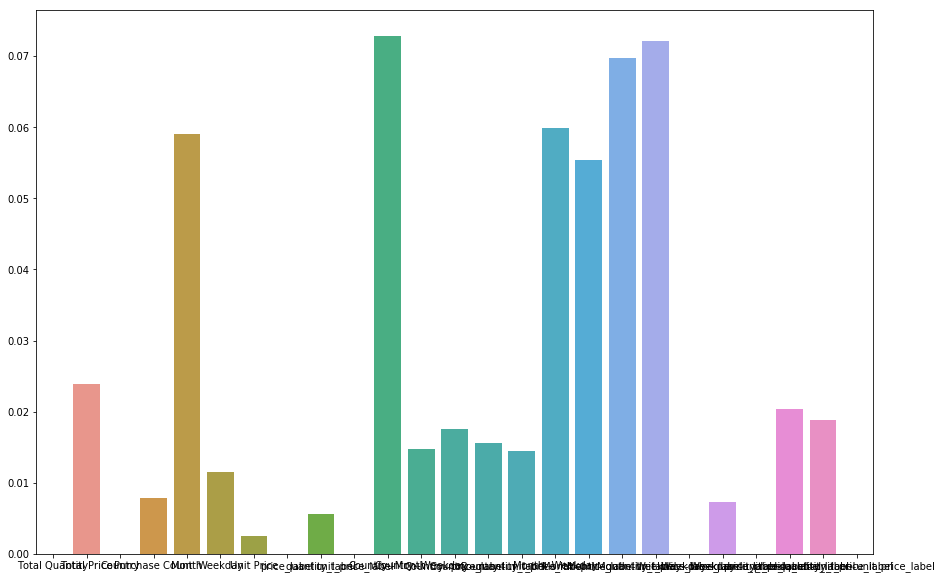

In [396]:
plt.figure(figsize=(15, 10))
sns.barplot(x=X_test_te.columns, y = gain)

## Phase 1

In [176]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [179]:
def metrics(y_pred, y_true):
    print('Accuracy:', accuracy_score(y_pred = y_pred, y_true = y_true))
    print('Precision:', precision_score(y_pred = y_pred, y_true = y_true))
    print('Recall:', recall_score(y_pred = y_pred, y_true = y_true))
    print('F1:', f1_score(y_pred = y_pred, y_true = y_true))

In [282]:
def get_scores(clf):
    clf = clf.fit(X_train_te_normal, y_train)
    print("metrics on test:")
    predicts = clf.predict(X_test_te_normal)
    metrics(y_pred=predicts, y_true=y_test)
    print("metrics on train:")
    predicts = clf.predict(X_train_te_normal)
    metrics(y_pred=predicts, y_true=y_train)

In [180]:
X_train_te_normal = X_train_te / X_train_te.max()
X_test_te_normal = X_test_te / X_train_te.max()

In [344]:
knn_clf = KNeighborsClassifier(n_neighbors=9)
get_scores(knn_clf)

metrics on test:
Accuracy: 0.7231121281464531
Precision: 0.7569141193595342
Recall: 0.8739495798319328
F1: 0.8112324492979719
metrics on train:
Accuracy: 0.7754868270332188
Precision: 0.7942145734163311
Recall: 0.9071518193224593
F1: 0.8469347910972277


In [252]:
test_results = []
train_results = []
for k in range(1, 50):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf = clf.fit(X_train_te_normal, y_train)
    test_results.append(clf.score(X_test_te_normal, y_test))
    train_results.append(clf.score(X_train_te_normal, y_train))

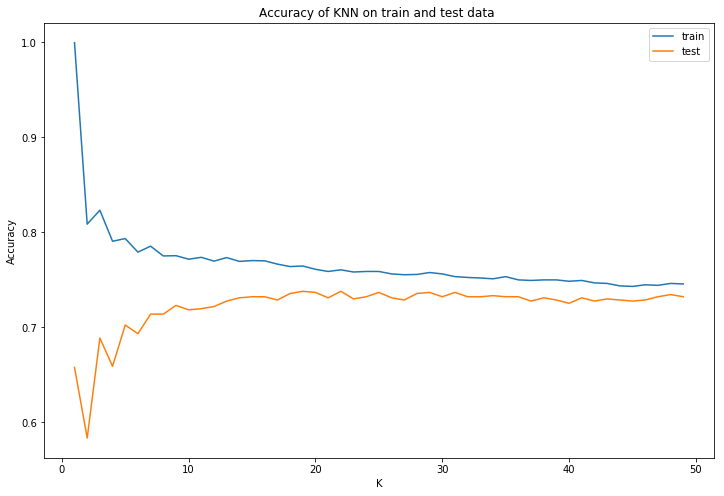

In [261]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, 50), train_results, label='train')
plt.plot(range(1, 50), test_results, label='test')
plt.title('Accuracy of KNN on train and test data ')
plt.xlabel('K')
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [346]:
lr_clf = LogisticRegression(solver='lbfgs', C = 9, max_iter=1000)
get_scores(lr_clf)

metrics on test:
Accuracy: 0.7254004576659039
Precision: 0.7503526093088858
Recall: 0.8941176470588236
F1: 0.8159509202453988
metrics on train:
Accuracy: 0.7623138602520045
Precision: 0.7788495891389782
Recall: 0.9117524048515265
F1: 0.8400770712909441


In [354]:
dt_clf = DecisionTreeClassifier(max_depth=1)
get_scores(dt_clf)

metrics on test:
Accuracy: 0.7379862700228833
Precision: 0.7723214285714286
Recall: 0.8722689075630252
F1: 0.819258089976322
metrics on train:
Accuracy: 0.7342497136311569
Precision: 0.772642564293701
Recall: 0.8670012547051443
F1: 0.8171068190776508


In [262]:
test_results = []
train_results = []
for k in range(1, 20):
    clf = DecisionTreeClassifier(max_depth = k)
    clf = clf.fit(X_train_te_normal, y_train)
    test_results.append(clf.score(X_test_te_normal, y_test))
    train_results.append(clf.score(X_train_te_normal, y_train))

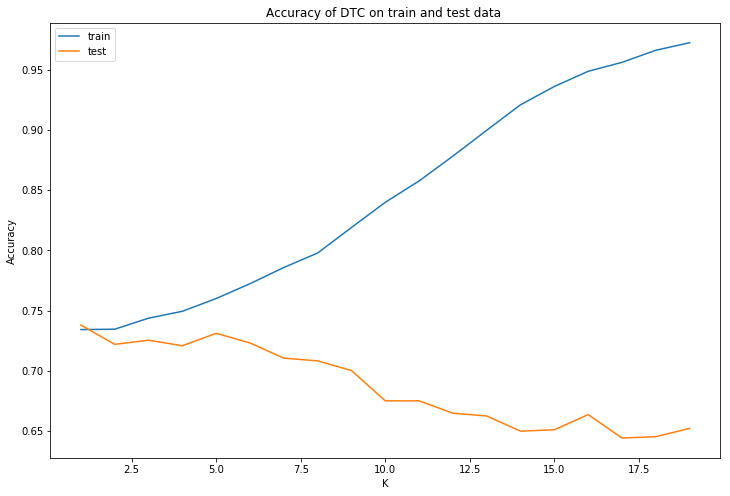

In [263]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, 20), train_results, label='train')
plt.plot(range(1, 20), test_results, label='test')
plt.title('Accuracy of DTC on train and test data ')
plt.xlabel('K')
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Phase 2

In [281]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier


In [286]:
knn = KNeighborsClassifier(n_neighbors = 9)
clf = BaggingClassifier(base_estimator=knn, max_features=0.5, n_estimators=50)
get_scores(clf)

metrics on test:
Accuracy: 0.7311212814645309
Precision: 0.7479338842975206
Recall: 0.9126050420168067
F1: 0.8221044663133988
metrics on train:
Accuracy: 0.7875143184421535
Precision: 0.7893997893997894
Recall: 0.9406106231702217
F1: 0.8583969465648855


In [287]:
knn = DecisionTreeClassifier(max_depth=1)
clf = BaggingClassifier(base_estimator=knn, max_features=0.5, n_estimators=20)
get_scores(clf)

metrics on test:
Accuracy: 0.7402745995423341
Precision: 0.7621082621082621
Recall: 0.8991596638655462
F1: 0.8249807247494217
metrics on train:
Accuracy: 0.7396907216494846
Precision: 0.7644539614561028
Recall: 0.8958594730238394
F1: 0.8249566724436742


In [291]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=8, max_depth=2)
get_scores(clf)

metrics on test:
Accuracy: 0.7356979405034325
Precision: 0.7466124661246613
Recall: 0.9260504201680673
F1: 0.8267066766691673
metrics on train:
Accuracy: 0.7385452462772051
Precision: 0.7508486082824168
Recall: 0.9251359263906316
F1: 0.8289301105489977


In [292]:
from sklearn.model_selection import GridSearchCV

In [309]:
param_grid = {'n_estimators': [1, 3, 7, 15, 30, 60, 100],
              'max_depth': range(1, 10), 
              'max_features': [0.1, 0.3, 0.5, 0.7, 0.9]}

gs = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=8, scoring = 'f1', verbose=2)
gs = gs.fit(X_train_te_normal, y_train)

Fitting 3 folds for each of 315 candidates, totalling 945 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 178 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 775 tasks      | elapsed:   16.4s
[Parallel(n_jobs=8)]: Done 945 out of 945 | elapsed:   25.0s finished


In [311]:
best_clf = gs.best_estimator_
get_scores(best_clf)

metrics on test:
Accuracy: 0.7322654462242563
Precision: 0.7449118046132972
Recall: 0.9226890756302522
F1: 0.8243243243243243
metrics on train:
Accuracy: 0.7580183276059564
Precision: 0.7627464309993202
Recall: 0.9385194479297365
F1: 0.8415525970373149


In [397]:
model = KNeighborsClassifier(3)
test_results = []
train_results = []
num_estimators = [1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 20, 25, 30, 65]
for k in num_estimators:
    clf = BaggingClassifier(base_estimator=model, max_features=0.5, n_estimators=k)
    clf = clf.fit(X_train_te_normal, y_train)
    test_results.append(clf.score(X_test_te_normal, y_test))
    train_results.append(clf.score(X_train_te_normal, y_train))


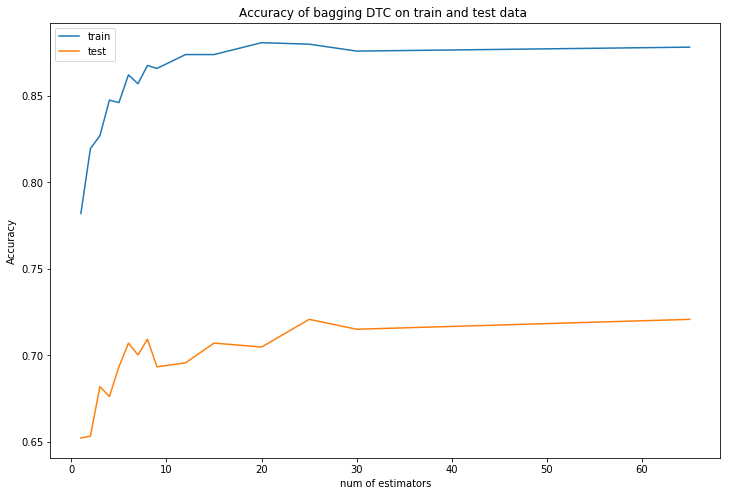

In [398]:
plt.figure(figsize=(12, 8))
plt.plot(num_estimators, train_results, label='train')
plt.plot(num_estimators, test_results, label='test')
plt.title('Accuracy of bagging DTC on train and test data ')
plt.xlabel('num of estimators')
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Using bootstrapping we have many weak models which use only a subset of features, thus are uncorrelated and are not the same. Using these methods variance will decrease and bias is likely to decrease(not providing enough data for our models may cause our models to differ much more and thus bias may be large)

In [342]:
from sklearn.ensemble import VotingClassifier

In [375]:
knn_clf = KNeighborsClassifier(n_neighbors=9)
lr_clf = LogisticRegression(solver='lbfgs', C = 9, max_iter=1000)
dt_clf = DecisionTreeClassifier(max_depth=1)
vc_clf = VotingClassifier([('knn', knn_clf), ('lr', lr_clf), ('dt', dt_clf)], voting='hard')
get_scores(vc_clf)

metrics on test:
Accuracy: 0.7345537757437071
Precision: 0.759656652360515
Recall: 0.892436974789916
F1: 0.8207109737248841
metrics on train:
Accuracy: 0.7666093928980527
Precision: 0.7842712842712842
Recall: 0.9092429945629443
F1: 0.84214603912454


In [372]:
knn_clf = KNeighborsClassifier(n_neighbors=9)
knn_predicts = knn_clf.fit(X_train_te_normal, y_train).predict(X_test_te_normal)

lr_clf = LogisticRegression(solver='lbfgs', C = 9, max_iter=1000)
lr_predicts = lr_clf.fit(X_train_te, y_train).predict(X_test_te)

dt_clf = DecisionTreeClassifier(max_depth=1)
dt_predicts = dt_clf.fit(X_train_te_normal, y_train).predict(X_test)



In [370]:
print((knn_predicts == lr_predicts).mean())
print((knn_predicts == dt_predicts).mean())
print((dt_predicts == lr_predicts).mean())


0.8924485125858124
0.8752860411899314
0.9096109839816934


Voting Classifier has a better performance but it's not much because all three models have almost the same prediction, thus not much would change when voting between them.

